In [11]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import itertools as it

path_root = os.path.join(os.environ['E3SM_ROOT'], 'inputdata', 'lnd', 'clm2', 'surfdata_map')
file_orig = os.path.join(path_root, 'landuse.timeseries_conus_erw_off_hist_simyr1850_c240712.nc')
file_temp = os.path.join(path_root, 'landuse.conus_erw.temp.nc')

# copy from the non-ERW file
os.system(f"cp {file_orig} {file_temp}")

hr = xr.open_dataset(file_temp)

In [12]:
# Grain sizes: 10-1000 um
# Application rates: 20-100 t/ha => 2-10 kg/m2
# Day of year: Jan 1 # 244 (Sep-1 in nonleap years)
mpft = 17
year_of_application = np.where(hr['time'].values == 1850)[0][0]
day_of_application = 1 # 244
namendspec = 10

# minerals_name = ['Wollastonite_CaSiO3', 'Forsterite_Mg2SiO4', 'Albite_NaAlSi3O8', 
#                 'Anorthite_CaAl2Si2O8', 'Epidote_Ca2FeAl2(SiO4)3(OH)', 'Calcite_CaCO3',
#                 'Labradorite_Ca0.6Na0.4Al1.6Si2.4O8', 'Augite_Ca0.9Mg0.9Na0.1Al0.4Fe0.2Si1.9O6',
#                 'Kfeldspar_KAlSi3O8', 'Enstatite_MgSiO3']
# normal alkali basalt (fast)
pct_basalt = np.array([0, 12, 0, 0, 0, 0, 43, 21, 6, 0])
# normal tholeiitic basalt (slow)
# pct_basalt = np.array([0, 0, 0, 0, 0, 0, 45, 34, 5, 3])

tuples = list(it.product(np.linspace(10, 1000, 10), np.linspace(2, 10, 10)))
tuples = [(1, 0)] + tuples

In [13]:
np.savetxt(os.path.join(os.environ['E3SM_ROOT'], 'inputdata', 'lnd', 'clm2', 'surfdata_map', 
                        'erw_ensemble_record.txt'), np.array(tuples))

In [14]:
# Please make sure each time step has valid values, because the streamfile reader
# is updating every year!
count = 0
for grain,app in tuples:
    doy = np.full([len(hr['time']), mpft, len(hr['lsmlat']), len(hr['lsmlon'])],
                  float(day_of_application))
    hr['SOIL_AMENDMENTS_DOY'] = xr.DataArray(doy, 
        dims = ['time','mpft','lsmlat','lsmlon'],
        attrs = {'long_name': 'soil amendment application day of year',
                 'units': 'day of year'})

    rate = np.zeros([len(hr['time']), mpft, len(hr['lsmlat']), len(hr['lsmlon'])])
    rate[year_of_application, :, :, :] = app
    hr['SOIL_AMENDMENTS_RATE'] = xr.DataArray(rate, 
        dims = ['time','mpft','lsmlat','lsmlon'],
        attrs = {'long_name': 'soil amendment application rate',
                 'units': 'kg/m2/yr'})

    size = np.full([len(hr['time']), len(hr['lsmlat']), len(hr['lsmlon'])], 
                   float(grain))
    hr['SOIL_AMENDMENTS_GRAINSIZE'] = xr.DataArray(size, 
        dims = ['time','lsmlat','lsmlon'],
        attrs = {'long_name': 'grain size of applied soil amendment',
                 'units': 'micro meters'})

    pct = np.full([len(hr['time']), namendspec, len(hr['lsmlat']), len(hr['lsmlon'])], np.nan)
    pct[:, :, :, :] = pct_basalt.reshape(1, -1, 1, 1)
    hr['SOIL_AMENDMENTS_PCT'] = xr.DataArray(pct, 
        dims = ['time','namendspec','lsmlat','lsmlon'],
        attrs = {'long_name': 'species fraction of applied soil amendment',
                 'units': 'percent'})

    hr['namendspec'] = xr.DataArray(
          np.arange(1, namendspec+1), dims = ['namendspec'],
          attrs = {'long_name': 'indices of species in soil amendment mixture (e.g. rock powder)',
                   'units': 'index'}
    )

    hr['mpft'] = xr.DataArray(
          np.arange(1, mpft+1), dims = ['mpft'],
          attrs = {'long_name': 'indices of natural PFTs and cfts, if any',
                   'units': 'index'}
    )

    file_dest = os.path.join(path_root, 'erw_ensemble', f'landuse.timeseries_conus_erw_on_hist_simyr1850_c240712_ensemble_{count}.nc')

    encoding = {}
    for var in hr.data_vars:
        if var in ['SOIL_AMENDMENTS_DOY', 'SOIL_AMENDMENTS_RATE', 'SOIL_AMENDMENTS_GRAINSIZE',
                   'SOIL_AMENDMENTS_PCT']:
            encoding[var] = {'_FillValue': 1e20}
        else:
            encoding[var] = {'_FillValue': None}

    hr.to_netcdf(file_dest, encoding=encoding, format = 'NETCDF4_CLASSIC')

    count = count + 1

In [15]:
hr.close()

os.system(f'rm {file_temp}')

0

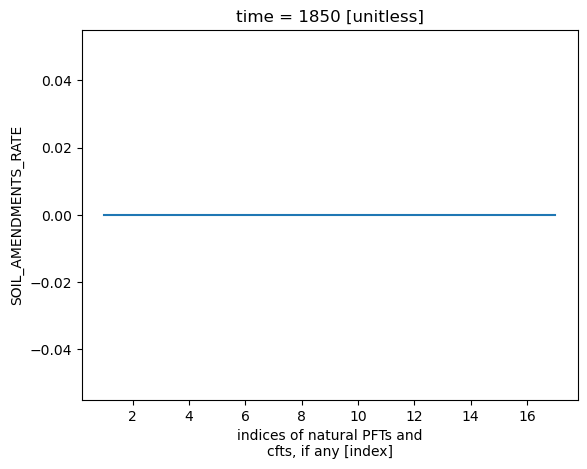

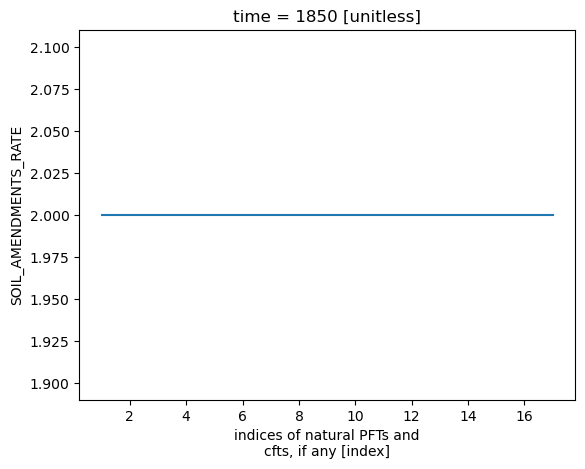

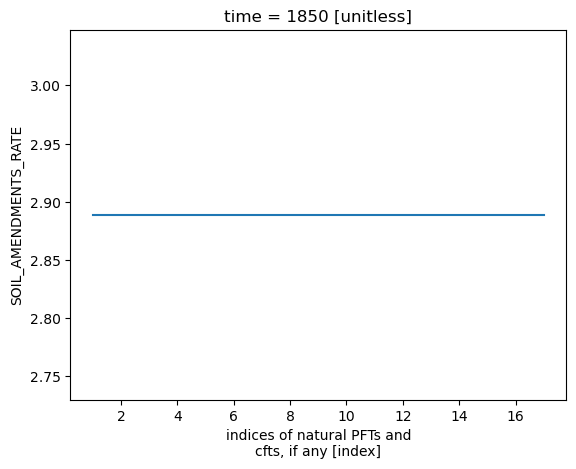

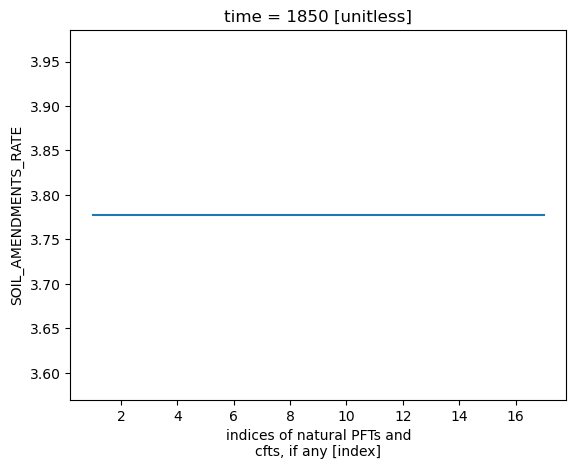

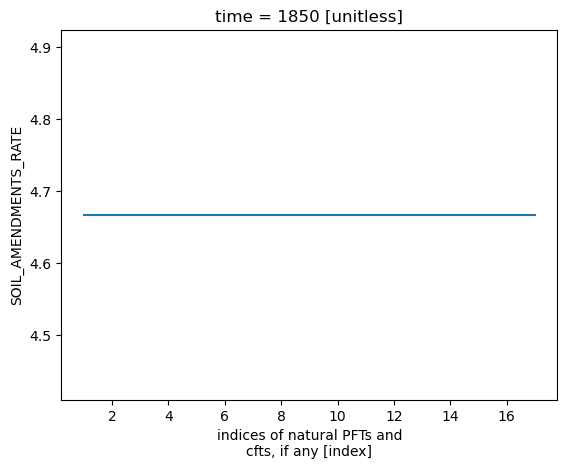

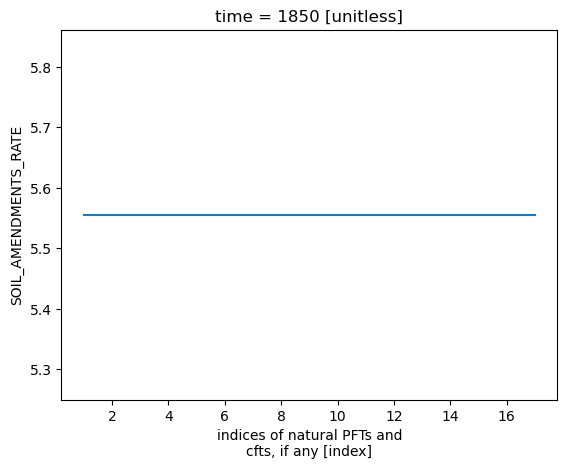

In [16]:
# Check the outcome
import matplotlib.pyplot as plt

count = 0
for grain,app in it.product(np.linspace(10, 1000, 10), np.linspace(20, 100, 10)):

    file_dest = os.path.join(path_root, 'erw_ensemble', f'landuse.timeseries_conus_erw_on_hist_simyr1850_c240712_ensemble_{count}.nc')
    hr = xr.open_dataset(file_dest)

    plt.figure()
    hr['SOIL_AMENDMENTS_RATE'][year_of_application, :, :, :].mean(axis = 2).mean(axis = 1).plot()

    hr.close()
    count = count + 1

    if count == 6:
        break